# Präsenzversuch zum Laval-Rotor

Name: Jakob Maurer 
Datum:  30.01.2024
Gruppe: 87

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Eignet sich der Versuchsaufbau um Eigenfrequenzen von Wellen mit Lasten zu ermitteln oder weichen berechnete und experimentell ermittelte Werte stark von einander ab.

## Erster Versuch: Prüfstand #04
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="image/heimversuch1.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

### Versuchsauswertung

In [277]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json
import matplotlib.colors as colors

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [278]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_091353_lavalrotor_87_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_091353_lavalrotor_87_04.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [279]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data\\data_20240115_091353_lavalrotor_87_04\\1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data\\data_20240115_091353_lavalrotor_87_04\\1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data\\data_20240115_091353_lavalrotor_87_04\\1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data\\data_20240115_091353_lavalrotor_87_04\\1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sen

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [280]:
# interpolationszeitpunkte werden erzeugt
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [281]:
#open hdf5 
f = h5py.File("measurement_data/"+"data_20240115_091353_lavalrotor_87_04/"+"data_20240115_091353_lavalrotor_87_04.h5")

#leere listen erstellen
acc_x=[]
acc_y=[]
acc_z=[]

time=   []
rpm=    []

#Daten aus hdf5 mit keys auslesen
for i in range(len(f.keys())):
    acc_x.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"]))
    acc_y.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"]))
    acc_z.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"]))

    time.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"]))
    rpm.append(np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"]).item())


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [282]:
importlib.reload(m_postprocessing)  # reload functions

#Listen für totale geschwindigkeit, interpolierte geschwindigkeiten und die scaled data
accel_ges=[]
accel_int=[]
fft_scale=[]

#pro greschwindigkeitsabschnitt werden Daten interpoliert
for i in range(len(f.keys())):
    accel_ges.append(m_postprocessing.get_vec_accel(acc_x[i],acc_y[i],acc_z[i]))
    accel_int.append(m_postprocessing.interpolation(time[i],accel_ges[i],interpolation_points))
    fft_scale.append(m_postprocessing.my_fft_scaled(accel_int[i],interpolation_points))

# Matrix erzeugen aus interpolierten werten
A=[]
for i in range(len(f.keys())):
    A.append(fft_scale[i][0])
print(np.shape(A))

(20, 1001)


#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

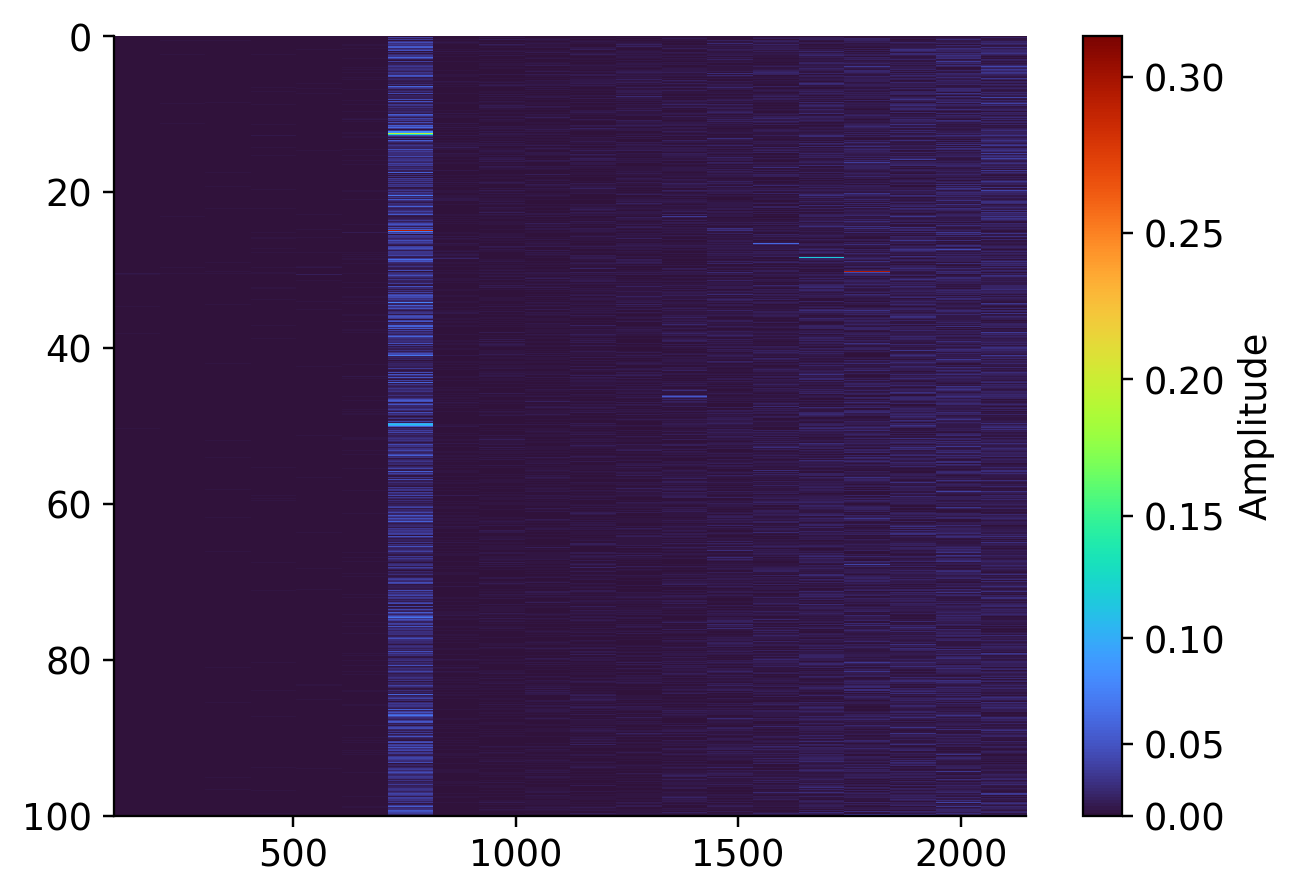

In [283]:

c = plt.imshow(np.transpose(A), extent=[min(rpm), max(rpm),  max(fft_scale[0][1]), min(fft_scale[0][1])], aspect='auto'
               , cmap='turbo',interpolation='none', norm=colors.PowerNorm(gamma=1.3))

# colorbar erzeugt um Amplituden ablesen zu können
plt.colorbar(c, label='Amplitude')
    

## Zweiter Datensatz: Prüfstand #02

#### 1. Einlesen der Mess- und Metadaten

In [284]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

# dict erstellen

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)


#Datenstruktur

#open hdf5
f = h5py.File("measurement_data/"+"data_20240102_100928_lavalrotor_01_02/"+"data_20240102_100928_lavalrotor_01_02.h5")

#leere Listen erstellen
acc_x=[]
acc_y=[]
acc_z=[]

time=   []
rpm=    []

#Daten aus HDF5 mit Keys auslesen
for i in range(len(f.keys())):
    acc_x.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"]))
    acc_y.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"]))
    acc_z.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"]))

    time.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"]))
    rpm.append(np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"]).item())






{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data\\data_20240102_100928_lavalrotor_01_02\\1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data\\data_20240102_100928_lavalrotor_01_02\\1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data\\data_20240102_100928_lavalrotor_01_02\\1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data\\data_20240102_100928_lavalrotor_01_02\\1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sen

#### 2. Verarbeitung der Messdaten

In [285]:
importlib.reload(m_postprocessing)  # reload functions
accel_ges=[]
accel_int=[]
fft_scale=[]

for i in range(len(f.keys())):
    accel_ges.append(m_postprocessing.get_vec_accel(acc_x[i],acc_y[i],acc_z[i]))
    accel_int.append(m_postprocessing.interpolation(time[i],accel_ges[i],interpolation_points))
    fft_scale.append(m_postprocessing.my_fft_scaled(accel_int[i],interpolation_points))

A=[]
for i in range(len(f.keys())):
    A.append(fft_scale[i][0])
print(np.shape(A))

(41, 1001)


#### 3. Darstellung mittels Campbell-Diagramm

In [286]:
c = plt.imshow(np.transpose(A), extent=[min(rpm), max(rpm),  max(fft_scale[0][1]), min(fft_scale[0][1])], aspect='auto'
               , cmap='turbo',interpolation='none', norm=colors.PowerNorm(gamma=1.3))

# Add colorbar to plot to read amplitude values
plt.colorbar(c, label='Amplitude')

## Dritter Datensatz: Prüfstand #03

#### 1. Einlesen der Mess- und Metadaten

In [287]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

# dict erstellen

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

#Datenstruktur

f = h5py.File("measurement_data/"+"data_20240102_112539_lavalrotor_01_03/"+"data_20240102_112539_lavalrotor_01_03.h5")

#Leere listen erstellen die später entsprechende daten enthalten
acc_x=[]    
acc_y=[]
acc_z=[]

time=   []
rpm=    []

for i in range(len(f.keys())):      #Daten werden in Listen gespeichert, es wird über die lastintervalle geloopt
    acc_x.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"]))
    acc_y.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"]))
    acc_z.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"]))

    time.append(np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"]))
    rpm.append(np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"]).item())



{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data\\data_20240102_112539_lavalrotor_01_03\\1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data\\data_20240102_112539_lavalrotor_01_03\\1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data\\data_20240102_112539_lavalrotor_01_03\\1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data\\data_20240102_112539_lavalrotor_01_03\\1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sen

#### 2. Verarbeitung der Messdaten

In [288]:
importlib.reload(m_postprocessing)  # reload functions


accel_ges=[]
accel_int=[]
fft_scale=[]

for i in range(len(f.keys())):
    accel_ges.append(m_postprocessing.get_vec_accel(acc_x[i],acc_y[i],acc_z[i]))
    accel_int.append(m_postprocessing.interpolation(time[i],accel_ges[i],interpolation_points))
    fft_scale.append(m_postprocessing.my_fft_scaled(accel_int[i],interpolation_points))

A=[]
for i in range(len(f.keys())):
    A.append(fft_scale[i][0])
print(np.shape(A))

(20, 1001)


#### 3. Darstellung mittels Campbell-Diagramm

In [289]:
c = plt.imshow(np.transpose(A), extent=[min(rpm), max(rpm),  max(fft_scale[0][1]), min(fft_scale[0][1])], aspect='auto'
               , cmap='turbo',interpolation='none', norm=colors.PowerNorm(gamma=1.3))

# colorbar generiert um Amplituden Werte zuordnen zu können
plt.colorbar(c, label='Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Experimentell ermittelte Eigenfrequenz stimmt relativ genau mit der analytisch ermittelten Zahl überein. Die Amplituden wurden in diesem Band jedoch durch einen Anschlag limitiert. Dieser führt zu einem insgesamt sehr hervorstechenden Band in dem viele Frequenzen eingebracht werden die nicht die Eigenfrequenz sind. In diesem Teil lässt sich über das System leider keine gute ausssage treffen. Man müsste das experiment noch einmal ohne die LKoimitierung durchführun um auch in diesem Bereich eine klare Aussage treffen zu können.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Dire Generierung der Daten für den Versuch war weniger interessant als die Kalorimetrie, da sie nahzu von alleine erzeugt wurden. Die Verarbeiteung der Daten hat mir zwar wenig über die Interpolation an sich vermittelt, jedoch wurde mir das verarbeiten von Datensäzten und die nutzung von campbell plots näher gebracht.